<a href="https://colab.research.google.com/github/electricshadok/notebooks/blob/main/diffusion_toy_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Understanding Diffusion Process

This notebook demonstrates how to build and train a diffusion model to learn and generate a simple 2D distribution.

Features

- Implement DDPM and DDIM

Improvement:
- The generation of new samples is not great yet  ❌
- Add LDMs or score-based models.



## Packages

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import torch
import torch.nn as nn
import torch.optim as optim

## 1. Generate Synthetic Data

We create a dataset of 2D points sampled from a Gaussian Mixture Model (GMM). This simulates data from a real-world distribution that we want the diffusion model to learn.

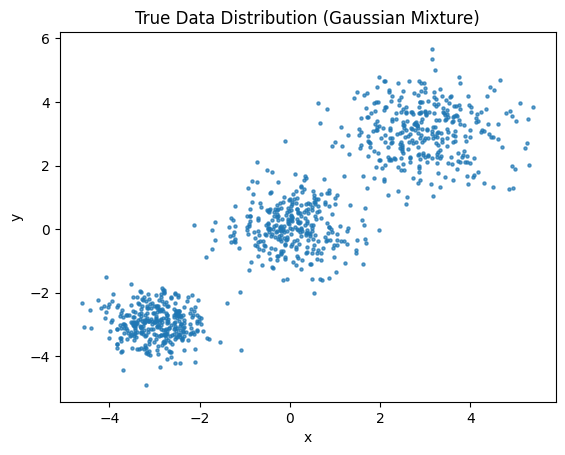

In [2]:
NUM_POINTS = 1000  # Total number of points
SEED = 42  # Seed for reproducibility

# Create synthetic data: Gaussian mixture
def sample_gaussian_mixture(n_samples, means, covs, seed=None):
    if seed is not None:
        np.random.seed(seed)
    n_components = len(means)
    samples = []
    for _ in range(n_samples):
        k = np.random.choice(n_components)  # Randomly select one Gaussian component
        sample = np.random.multivariate_normal(means[k], covs[k])
        samples.append(sample)
    return np.array(samples)

# Parameters of the Gaussian mixture
means = [[0, 0], [3, 3], [-3, -3]]
covs = [np.eye(2) * 0.5, np.eye(2) * 0.8, np.eye(2) * 0.3]

# Generate data
X = sample_gaussian_mixture(NUM_POINTS, means, covs, seed=SEED)

# Visualize the synthetic data
plt.scatter(X[:, 0], X[:, 1], s=5, alpha=0.7)
plt.title("True Data Distribution (Gaussian Mixture)")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

## 2. Diffusion Model (Forward and Reverse Diffusion)

**Forward Diffusion Process (Adding Noise)**

The **forward diffusion process** gradually adds Gaussian noise:

$$q(x_t | x_0) = N(x_t ; \sqrt{\bar{\alpha}_t} x_0, (1 - \bar{\alpha}_t) I)$$

Using the reparameterization trick, we can express $x_t$ as:

$$x_t = \sqrt{\bar{\alpha}_t} x_0 + \sqrt{1 - \bar{\alpha}_t} \cdot \epsilon, \quad \epsilon \sim N(0, I)$$

where:
- $x_t$ is the **noisy sample** at step $t$.
- $x_0$ is the **original data**.
- $\bar{\alpha}_t = \prod_{s=1}^{t} (1 - \beta_s)$ is the **cumulative noise schedule**.
- $\epsilon \sim N(0, I)$ **Gaussian noise** sampled at each step.

**Reverse Diffusion Process (Denoising)**

The **reverse process** gradually removes noise step by step, using a **denoising model** trained to predict the noise at each timestep. This formulation is from **denoising diffusion probabilistic models (DDPMs) - Ho et al., 2020**


$$p(x_{t-1} | x_t) = N(x_{t-1} ; \mu_{\theta}(x_t, t), \sigma_t^2 I)$$


where the predicted mean $\mu_{\theta}(x_t, t)$ is given by:

$$\mu_{\theta}(x_t, t) = \frac{1}{\sqrt{\alpha_t}} \left( x_t - \frac{1 - \alpha_t}{\sqrt{1 - \bar{\alpha}_t}} \cdot \epsilon_{\theta}(x_t, t) \right)$$

The denoising step to estimate $x_{t-1}$ is then

$$x_{t-1} = \mu_{\theta}(x_t, t)+ \sigma_t z$$

where:

- $p(x_{t-1} | x_t)$ represents the probability distribution of $x_{t-1}$ conditioned on  $x_t$ .
- $\mu_{\theta}(x_t, t)$ is the **predicted mean** for denoising.
- $\epsilon_{\theta}(x_t, t)$ is the **predicted noise** estimated by the model.
- $\sigma_t$ is the **standard deviation** used in the stochastic sampling process.
- $z \sim N(0, I)$ is **Gaussian noise** added to introduce randomness.


While **DDPM** adds noise at every step, **Denoising Diffusion Implicit Models (DDPIM) - Song et al., 2021** removes the stochastic term for faster, deterministic sampling with fewer steps.

In DDIM, we instead use a deterministic update rule:

$$x_{t-1} = \sqrt{\bar{\alpha}_{t-1}} \cdot \hat{x}_0 + \sqrt{1 - \bar{\alpha}_{t-1}} \cdot \epsilon_{\theta}(x_t, t)$$

where:

$$\hat{x}_0 = \frac{x_t - \sqrt{1 - \bar{\alpha}_t} \cdot \epsilon_{\theta}(x_t, t)}{\sqrt{\bar{\alpha}_t}}$$


To interpolate between **DDPM** and **DDIM**, we introduce the parameter
$\eta$ (which was missing in the initial DDIM implementation):


$$x_{t-1} = \sqrt{\bar{\alpha}_{t-1}} \cdot \hat{x}_0 + \sqrt{1 - \bar{\alpha}_{t-1} - \sigma_t^2} \cdot \epsilon_{\theta}(x_t, t) + \sigma_t z$$

where:

$$\sigma_t^2 = \eta^2 \cdot \frac{(1 - \bar{\alpha}_{t-1})}{(1 - \bar{\alpha}_t)} \cdot (1 - \alpha_t)$$

- $\eta=1$ this behaves like **DDPM (fully stochastic)**.

- $\eta=0$, the **random noise is removed**, making the process **fully deterministic (DDIM)**.




In [3]:
INPUT_DIM = 2  # Data is 2D
HIDDEN_DIM = 4
DIFFUSION_STEPS = 100
BATCH_SIZE = 32
NUM_SAMPLES = 4

class Diffuser(nn.Module):
    def __init__(self, input_dim: int, hidden_dim: int, steps: int):
        super(Diffuser, self).__init__()
        self.diffusion_steps = steps

        # Define noise schedule (β values)
        self.beta = torch.linspace(0.0001, 0.02, steps)
        self.alpha = 1.0 - self.beta
        self.alpha_bar = torch.cumprod(self.alpha, dim=0)

        # Simple MLP model to predict noise
        self.denoiser = nn.Sequential(
            nn.Linear(input_dim + 1, hidden_dim), # +1 for timestep embedding
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim)
        )

    def forward(self, x, t):
        # redict noise given a noisy input x at timestep t
        # Normalize `t` (convert int to float, then reshape)
        t_emb = (t.float() / self.diffusion_steps).unsqueeze(1)

        # Concatenate timestep embedding with input
        emb = torch.cat((x, t_emb), dim=1)  # Shape: (batch_size, input_dim + 1)

        # Predict the noise added to `x`
        noise_pred = self.denoiser(emb)

        return noise_pred  # Shape: (batch_size, input_dim)

    def forward_diffusion(self, x, t):
        noise = torch.randn_like(x)
        x_noisy = noise

        # Ensure alpha_bar[t] has the correct shape (batch_size, 1)
        alpha_bar_t = self.alpha_bar[t].unsqueeze(1)  # Shape: (32, 1)

        x_noisy = torch.sqrt(alpha_bar_t) * x + torch.sqrt(1 - alpha_bar_t) * noise
        return x_noisy, noise  # Return noisy input and actual noise

    def reverse_diffusion(self, n_samples, ddim_eta=0.0):
        # Generate new samples starting from pure noise
        # - If `ddim_eta=0`, it follows DDIM (deterministic).
        # - If `ddim_eta=1`, it follows DDPM (stochastic).
        x = torch.randn(n_samples, 2)  # Start with Gaussian noise
        for t in reversed(range(self.diffusion_steps)):
            t_tensor = torch.full((n_samples,), t, dtype=torch.float32)

            # Predict noise
            noise_pred = self.forward(x, t_tensor)

            # Compute x_0 estimate
            x0_pred = (x - torch.sqrt(1 - self.alpha_bar[t]) * noise_pred) / torch.sqrt(self.alpha_bar[t])

            # Compute sigma_t (controls stochasticity)
            sigma_t = ddim_eta * torch.sqrt((1 - self.alpha_bar[t - 1]) / (1 - self.alpha_bar[t]) * (1 - self.alpha[t]))

            # Compute direction_xt (deterministic term)
            direction_xt = torch.sqrt(1 - self.alpha_bar[t - 1] - sigma_t**2) * noise_pred

            # Compute x_{t-1} using DDIM update rule
            x = torch.sqrt(self.alpha_bar[t - 1]) * x0_pred + direction_xt

            # Optional: If `ddim_eta > 0`, add noise (closer to DDPM)
            if ddim_eta > 0:
                x += sigma_t * torch.randn_like(x)

        return x


subset_x = X[:BATCH_SIZE]
x = torch.tensor(subset_x, dtype=torch.float32)
t = torch.randint(0, DIFFUSION_STEPS, (BATCH_SIZE,))

diffuser = Diffuser(INPUT_DIM, HIDDEN_DIM, DIFFUSION_STEPS)

print("-- Forward --")
y = diffuser(x, t)
print(f"Input : x:{x.shape}, t:{t.shape}")
print(f"Output(predicted noise) : {y.shape}")

print("-- Forward diffusion --")
x_noisy, noise = diffuser.forward_diffusion(x, t)
print(f"Input : x:{x.shape}, t:{t.shape}")
print(f"Output: noisy input:{x_noisy.shape}, noise:{noise.shape}")


print("-- Reverse diffusion --")
samples = diffuser.reverse_diffusion(NUM_SAMPLES)
print(f"Input: {NUM_SAMPLES} samples")
print(f"Output: sample shapes {samples.shape}")

-- Forward --
Input : x:torch.Size([32, 2]), t:torch.Size([32])
Output(predicted noise) : torch.Size([32, 2])
-- Forward diffusion --
Input : x:torch.Size([32, 2]), t:torch.Size([32])
Output: noisy input:torch.Size([32, 2]), noise:torch.Size([32, 2])
-- Reverse diffusion --
Input: 4 samples
Output: sample shapes torch.Size([4, 2])


## 3. Training

Lets train the diffusion model

In [4]:
import torch.optim as optim
from tqdm import tqdm

def train_diffuser(diffuser, dataset, batch_size=32, num_epochs=500, lr=1e-3):
    """Train the diffusion model to learn noise removal"""
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
    optimizer = optim.Adam(diffuser.parameters(), lr=lr)
    loss_fn = nn.MSELoss()

    for epoch in tqdm(range(num_epochs), desc="Training Progress"):
        total_loss = 0
        for batch in dataloader:
            x_batch = batch[0]
            t = torch.randint(0, diffuser.diffusion_steps, (x_batch.size(0),))  # Random timesteps

            # Forward diffusion: Add noise
            x_noisy, noise = diffuser.forward_diffusion(x_batch, t)

            # Predict noise
            noise_pred = diffuser(x_noisy, t)

            # Compute loss
            loss = loss_fn(noise_pred, noise)  # Compare predicted noise vs. actual noise

            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        if epoch % 100 == 0:
            print(f"Epoch {epoch}, Loss: {total_loss / len(dataloader):.4f}")


# Convert dataset to PyTorch tensors
X_tensor = torch.tensor(X, dtype=torch.float32)
dataset = torch.utils.data.TensorDataset(X_tensor)

# Train the diffusion model
train_diffuser(diffuser, dataset, batch_size=BATCH_SIZE, num_epochs=1000, lr=1e-3)

Training Progress:   0%|          | 1/1000 [00:00<06:08,  2.71it/s]

Epoch 0, Loss: 1.0991


Training Progress:  10%|█         | 104/1000 [00:06<00:48, 18.36it/s]

Epoch 100, Loss: 0.8032


Training Progress:  20%|██        | 204/1000 [00:12<00:44, 17.89it/s]

Epoch 200, Loss: 0.8304


Training Progress:  30%|███       | 304/1000 [00:19<00:45, 15.16it/s]

Epoch 300, Loss: 0.8113


Training Progress:  40%|████      | 404/1000 [00:25<00:33, 18.06it/s]

Epoch 400, Loss: 0.8048


Training Progress:  50%|█████     | 504/1000 [00:36<00:27, 18.21it/s]

Epoch 500, Loss: 0.8204


Training Progress:  60%|██████    | 603/1000 [00:43<00:22, 17.53it/s]

Epoch 600, Loss: 0.8097


Training Progress:  70%|███████   | 703/1000 [00:49<00:16, 18.25it/s]

Epoch 700, Loss: 0.7833


Training Progress:  80%|████████  | 803/1000 [00:55<00:15, 12.41it/s]

Epoch 800, Loss: 0.8216


Training Progress:  90%|█████████ | 904/1000 [01:01<00:05, 17.86it/s]

Epoch 900, Loss: 0.7923


Training Progress: 100%|██████████| 1000/1000 [01:07<00:00, 14.83it/s]


## 4. Generate New Samples

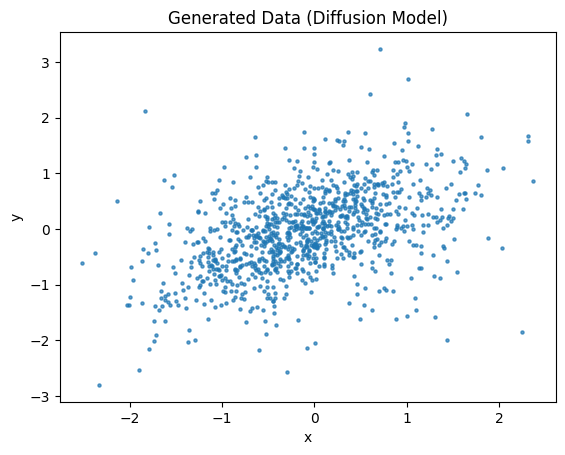

In [6]:
# Generate new samples using the trained diffusion model
with torch.no_grad():
    generated_samples = diffuser.reverse_diffusion(1000).numpy()

# Visualize generated samples
plt.scatter(generated_samples[:, 0], generated_samples[:, 1], s=5, alpha=0.7)
plt.title("Generated Data (Diffusion Model)")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

## Resources

[1] *Denoising Diffusion Probabilistic Models (DDPM)* - Ho et al., 2020  [https://arxiv.org/abs/2006.11239](https://arxiv.org/abs/2006.11239)

[2] *Denoising Diffusion Implicit Models (DDPIM)* - Song et al., 2021  [https://arxiv.org/abs/2010.02502](https://arxiv.org/abs/2010.02502)